In [1]:
# working note
## this is the mocking text model, AUC reach 0.78 befroe tuning hyperparameter
## this model will be used in two way
## first, this IS the *model 1*, which is the model made of e-record only
## second, this model will serve as the based ingrident of *model 3s*
### model 3A will be this model plus some kind of identiable (?) feature from the CT image, e.g proportion of fat..
### model 3B will be this model plus the feature from either VGG or autoencoder, e.g. the tensor from last hidden layer
#### it is possible to have model 1 re-train under only one hospital record (with manualy opt out)
#### but this is up to decide

In [2]:
# Loading basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pydicom
import SimpleITK as sitk
import random
import time
import joblib

In [3]:
# Loading modeling libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, roc_auc_score, classification_report, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
import tensorflow as tf
from tensorflow import keras

In [4]:
# Loading XGB libraries
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

In [5]:
import shap
shap.initjs()

In [6]:
def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=0)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples.T

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            if show_normed:
                ax.text(x=j,
                        y=i,
                        s=cell_text,
                        va='center',
                        ha='center',
                        color="white" if normed_conf_mat[i, j] > 0.5
                        else "black")
            else:
                ax.text(x=j,
                        y=i,
                        s=cell_text,
                        va='center',
                        ha='center',
                        color="white" if conf_mat[i, j] > np.max(conf_mat)/2
                        else "black")
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax


In [7]:
df = pd.read_csv('../abt/ABT2.csv')
#df

In [8]:
df.head()

,PID_STUDY,PID,ID,StudyInstanceUid,PAT_STUDY,case,SEX,BIRTHDAY,PATIENT_AGE,STUDY_DATE,...,C1_C_YN_past3mo,C1_4_YN_past3mo,C1_D_YN_past3mo,C1_2_YN_past3mo,C1_F_YN_past3mo,C1_6_YN_past3mo,C1_8_YN_past3mo,C1_G_YN_past3mo,C1_1_YN_past3mo,C1_9_YN_past3mo
0,psuedoID_0001_S001,psuedoID_0001,1.2.840.4617251246150175204137172199922377412680,1.2.840.52234177712510410248100181209188129412573,psuedoID_00011.2.840.5223417771251041024810018...,1,1,1936-10-05,81,2018-05-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,psuedoID_0002_S001,psuedoID_0002,1.2.840.115801116189224918693562471361061736619,1.2.840.17321436186174151857619612929141411101...,psuedoID_00021.2.840.1732143618617415185761961...,1,1,1950-03-06,68,2018-07-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,psuedoID_0003_S001,psuedoID_0003,1.2.840.39171128759759431061437311515024288129254,1.2.840.137891474015176123923111219516920646109,psuedoID_00031.2.840.1378914740151761239231112...,1,1,1937-07-12,80,2018-05-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,psuedoID_0004_S001,psuedoID_0004,1.2.840.18132111781482106246251981641121161052...,1.2.840.133140186211161223196179932489043534336,psuedoID_00041.2.840.1331401862111612231961799...,1,1,1945-01-15,73,2018-04-09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,psuedoID_0005_S001,psuedoID_0005,1.2.840.5840132263014111212910632001518425224348,1.2.840.14611381252228199267198167212200105206...,psuedoID_00051.2.840.1461138125222819926719816...,1,1,1941-12-11,77,2018-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
list(df.columns) 

['PID_STUDY',
 'PID',
 'ID',
 'StudyInstanceUid',
 'PAT_STUDY',
 'case',
 'SEX',
 'BIRTHDAY',
 'PATIENT_AGE',
 'STUDY_DATE',
 'OP_infectious_A_forever',
 'OP_infectious_B_forever',
 'OP_infectious_C_forever',
 'OP_infectious_D_forever',
 'OP_infectious_E_forever',
 'OP_infectious_F_forever',
 'OP_infectious_G_forever',
 'OP_neoplasms_A_forever',
 'OP_neoplasms_B_forever',
 'OP_neoplasms_C_forever',
 'OP_neoplasms_D_forever',
 'OP_neoplasms_E_forever',
 'OP_neoplasms_F_forever',
 'OP_endocrine_A_forever',
 'OP_endocrine_B_forever',
 'OP_endocrine_C_forever',
 'OP_blood_A_forever',
 'OP_blood_B_forever',
 'OP_mental_A_forever',
 'OP_mental_B_forever',
 'OP_mental_C_forever',
 'OP_nervous_A_forever',
 'OP_nervous_B_forever',
 'OP_nervous_C_forever',
 'OP_nervous_D_forever',
 'OP_circulatory_A_forever',
 'OP_circulatory_C_forever',
 'OP_circulatory_D_forever',
 'OP_respiratory_A_forever',
 'OP_respiratory_B_forever',
 'OP_respiratory_C_forever',
 'OP_respiratory_D_forever',
 'OP_digestive_A_forever',
 'OP_digestive_B_forever',
 'OP_digestive_C_forever',
 'OP_digestive_D_forever',
 'OP_genitourinary_A_forever',
 'OP_genitourinary_B_forever',
 'OP_genitourinary_C_forever',
 'OP_genitourinary_D_forever',
 'OP_pregnancy_A_forever',
 'OP_pregnancy_B_forever',
 'OP_pregnancy_C_forever',
 'OP_pregnancy_D_forever',
 'OP_skin_A_forever',
 'OP_skin_B_forever',
 'OP_skin_C_forever',
 'OP_musculoskeletal_A_forever',
 'OP_musculoskeletal_B_forever',
 'OP_musculoskeletal_C_forever',
 'OP_congenita_A_forever',
 'OP_congenita_B_forever',
 'OP_perinatal_A_forever',
 'OP_symptoms_A_forever',
 'OP_symptoms_B_forever',
 'OP_symptoms_C_forever',
 'OP_injury_A_forever',
 'OP_injury_B_forever',
 'OP_injury_C_forever',
 'OP_injury_D_forever',
 'OP_injury_E_forever',
 'OP_injury_F_forever',
 'HP_infectious_A_forever',
 'HP_infectious_B_forever',
 'HP_infectious_C_forever',
 'HP_infectious_D_forever',
 'HP_infectious_E_forever',
 'HP_infectious_F_forever',
 'HP_infectious_G_forever',
 'HP_neoplasms_A_forever',
 'HP_neoplasms_B_forever',
 'HP_neoplasms_C_forever',
 'HP_neoplasms_D_forever',
 'HP_neoplasms_E_forever',
 'HP_neoplasms_F_forever',
 'HP_endocrine_A_forever',
 'HP_endocrine_B_forever',
 'HP_endocrine_C_forever',
 'HP_blood_A_forever',
 'HP_blood_B_forever',
 'HP_mental_A_forever',
 'HP_mental_B_forever',
 'HP_mental_C_forever',
 'HP_nervous_A_forever',
 'HP_nervous_B_forever',
 'HP_nervous_C_forever',
 'HP_nervous_D_forever',
 'HP_circulatory_A_forever',
 'HP_circulatory_C_forever',
 'HP_circulatory_D_forever',
 'HP_respiratory_A_forever',
 'HP_respiratory_B_forever',
 'HP_respiratory_C_forever',
 'HP_respiratory_D_forever',
 'HP_digestive_A_forever',
 'HP_digestive_B_forever',
 'HP_digestive_C_forever',
 'HP_digestive_D_forever',
 'HP_genitourinary_A_forever',
 'HP_genitourinary_B_forever',
 'HP_genitourinary_C_forever',
 'HP_genitourinary_D_forever',
 'HP_pregnancy_A_forever',
 'HP_pregnancy_B_forever',
 'HP_pregnancy_C_forever',
 'HP_pregnancy_D_forever',
 'HP_skin_A_forever',
 'HP_skin_B_forever',
 'HP_skin_C_forever',
 'HP_musculoskeletal_A_forever',
 'HP_musculoskeletal_B_forever',
 'HP_musculoskeletal_C_forever',
 'HP_congenita_A_forever',
 'HP_congenita_B_forever',
 'HP_perinatal_A_forever',
 'HP_symptoms_A_forever',
 'HP_symptoms_B_forever',
 'HP_symptoms_C_forever',
 'HP_injury_A_forever',
 'HP_injury_B_forever',
 'HP_injury_C_forever',
 'HP_injury_D_forever',
 'HP_injury_E_forever',
 'HP_injury_F_forever',
 'OP_APPL_DOT_q1_forever',
 'OP_APPL_DOT_q3_forever',
 'OP_APPL_DOT_p50_forever',
 'OP_APPL_DOT_mean_forever',
 'OP_APPL_DOT_max_forever',
 'HP_APPL_DOT_q1_forever',
 'HP_APPL_DOT_q3_forever',
 'HP_APPL_DOT_p50_forever',
 'HP_APPL_DOT_mean_forever',
 'HP_APPL_DOT_max_forever',
 'OP_freq_sum_forever',
 'HP_freq_sum_forever',
 'OP_freq_YN_forever',
 'HP_freq_YN_forever',
 'HP_HOSPDAYS_q1_forever',
 'HP_HOSPDAYS_q3_forever',
 'HP_HOSPDAYS_p50_forever',
 'HP_HOSPDAYS_mean_forever',
 'HP_HOSPDAYS_max_forever',
 'OP_freq_sum_HOSP_1_forever

In [59]:
# 移除欄位PART 1 : 將無法放入模型的欄位移除
unused_vars = ['PID_STUDY',
               'PID', 'ID', 'StudyInstanceUid', 'PAT_STUDY',
               'BIRTHDAY', 'STUDY_DATE'
              ]
df2 = df.drop(columns=unused_vars)
df2 = df2[df2.columns.drop(list(df2.filter(regex='C7_4A023N7_')))]
df2 = df2[df2.columns.drop(list(df2.filter(regex='C2_B2_')))]
df2 = df2[df2.columns.drop(list(df2.filter(regex='C3_027_')))]

In [60]:
# using k-fold
# training data ~ GKF != 1
# testing data ~ GBK == 1
test_GBK = df2['GKF'] == 1
df_test = df2[test_GBK].drop('GKF', axis=1)
df_train = df2[-test_GBK].drop('GKF', axis=1)

df_train.shape, df_test.shape

((5299, 22047), (1327, 22047))

In [61]:
## split the data
X_train = df_train.drop('case', axis=1)
X_test = df_test.drop('case', axis=1)
y_train = df_train['case']
y_test = df_test['case']

In [62]:
# modeling
model_xgb = XGBClassifier(n_estimators=80, learning_rate=0.1, max_depth=2)

model_xgb.fit(X_train, y_train)
model_xgb_pred = model_xgb.predict(X_test)
y_pred = model_xgb.predict_proba(X_test)[:, 1]

In [63]:
# 模型成果
print("Precision is {0:.2f}".format(precision_score(y_test, model_xgb_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, model_xgb_pred)))
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, model_xgb_pred)))
print("F1 is {0:.2f}".format(f1_score(y_test, model_xgb_pred)))
print("ROC_AUC is {0:.3f}".format(roc_auc_score(y_test, y_pred)))

Precision is 0.73
Recall is 0.46
Accuracy is 0.72
F1 is 0.56
ROC_AUC is 0.781


In [64]:
#joblib.dump(model_xgb, 'full_model_1')
#c=joblib.load('model1A')

In [65]:
# 自動的 2*2 table
pd.crosstab(y_test, model_xgb_pred, margins=True)

col_0,0,1,All
case,,,
0,727,88,815
1,279,233,512
All,1006,321,1327


In [66]:
DATA_Pred = pd.DataFrame(y_pred)
threshold = DATA_Pred.quantile(0.75)
threshold[0]

0.4893381744623184

In [67]:
DATA_Pred.columns = ['xgb_proba']
y_test_removeindex = pd.DataFrame(y_test).reset_index(drop=True)
DATA_Pred2 = pd.concat([DATA_Pred.xgb_proba, y_test_removeindex.case], axis=1)
DATA_Pred2['XGB_p'] = np.where(DATA_Pred['xgb_proba'] >= threshold[0], 1, 0)
DATA_Pred2.columns = ['xgb_proba', 'case', 'xgb_pred']
DATA_Pred2

,xgb_proba,case,xgb_pred
0,0.679638,1,1
1,0.334685,1,0
2,0.956496,1,1
3,0.869666,1,1
4,0.538172,1,1
...,...,...,...
1322,0.404540,0,0
1323,0.168986,0,0
1324,0.173772,0,0
1325,0.176282,0,0


In [68]:
#切檻後的 2*2 table
#pd.crosstab(DATA_Pred2.xgb_pred, DATA_Pred2.case, margins = True)

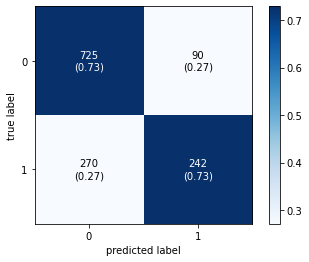

In [69]:
# 視覺化
binary = confusion_matrix(DATA_Pred2.case, DATA_Pred2.xgb_pred)
# class_names = ['normal', 'higher']
fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
#                                 class_names=class_names
                               )
plt.show()

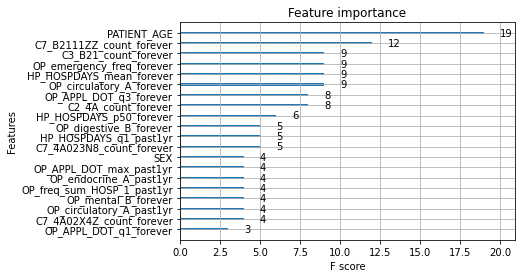

In [70]:
plot_importance(model_xgb, max_num_features=20, importance_type='weight')

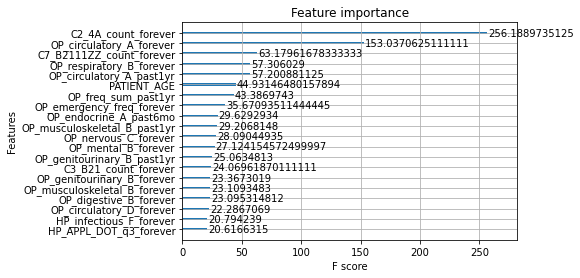

In [71]:
plot_importance(model_xgb, max_num_features=20, importance_type='gain')

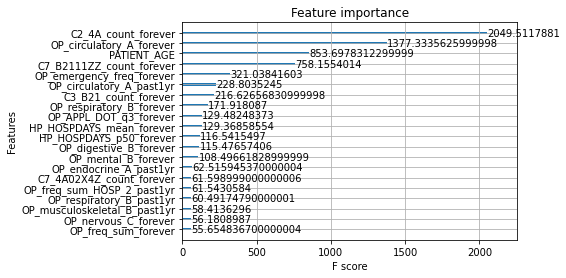

In [72]:
plot_importance(model_xgb, max_num_features=20, importance_type='total_gain')

In [73]:
explainer = shap.TreeExplainer(model=model_xgb)
shap_values = explainer.shap_values(X_test)
shap_values

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


array([[ 0.02163075,  0.17628656,  0.00464722, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03884651,  0.17605059, -0.00342615, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02513485,  0.09081525, -0.00342615, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.05629453,  0.21758941, -0.00342615, ...,  0.        ,
         0.        ,  0.        ],
       [-0.045322  , -0.06502039, -0.00342615, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04847636, -0.13885401, -0.00342615, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

invalid value encountered in greater
invalid value encountered in less


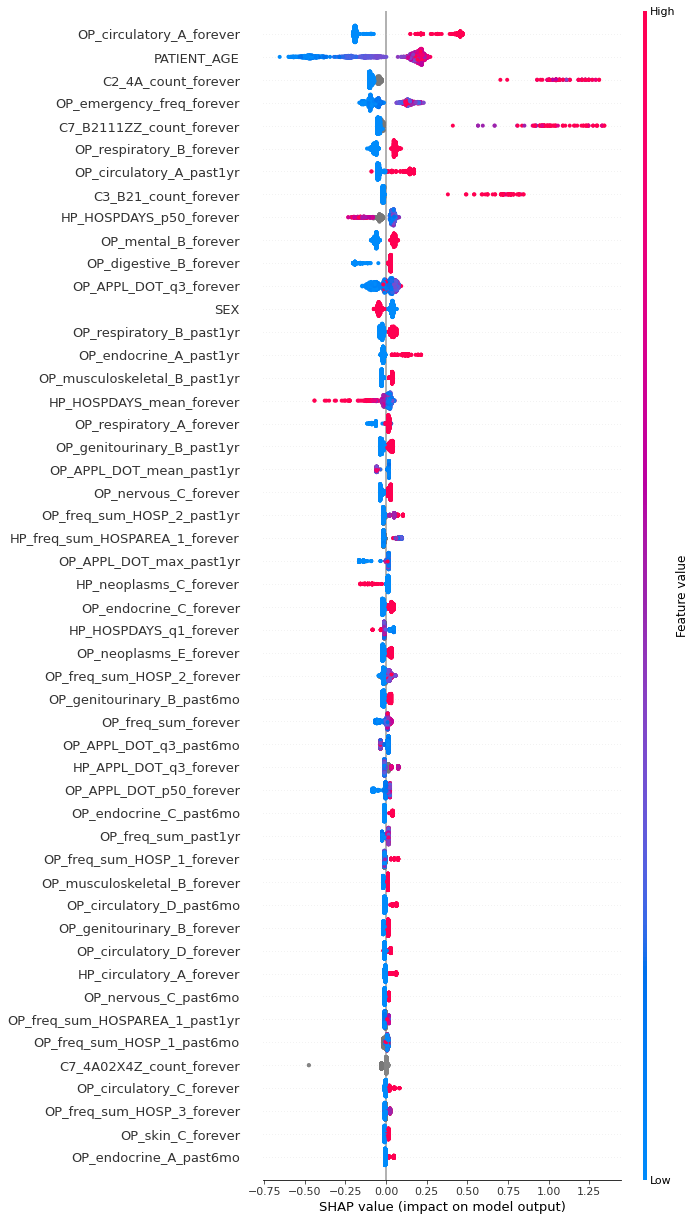

In [74]:
#shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, max_display = 50)

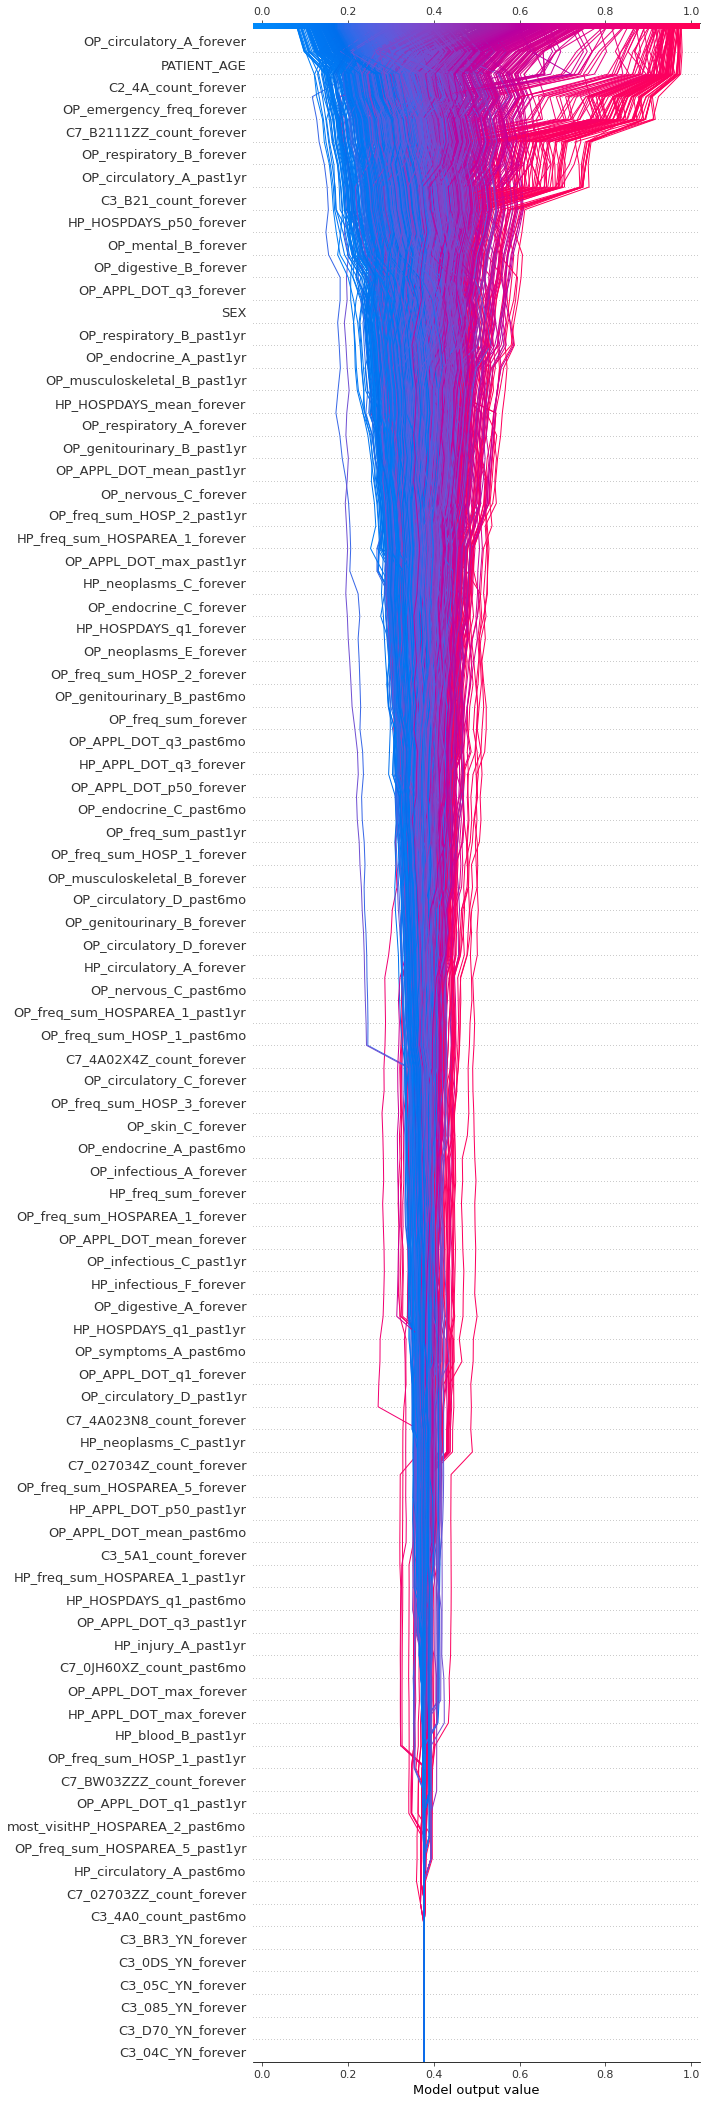

In [75]:
# shap.decision_plot(explainer.expected_value, shap_values, link='logit', features=X_test)
shap.decision_plot(explainer.expected_value,
                   shap_values,
                   link='logit',
                   features=X_test, feature_display_range=slice(-1, -91, -1))

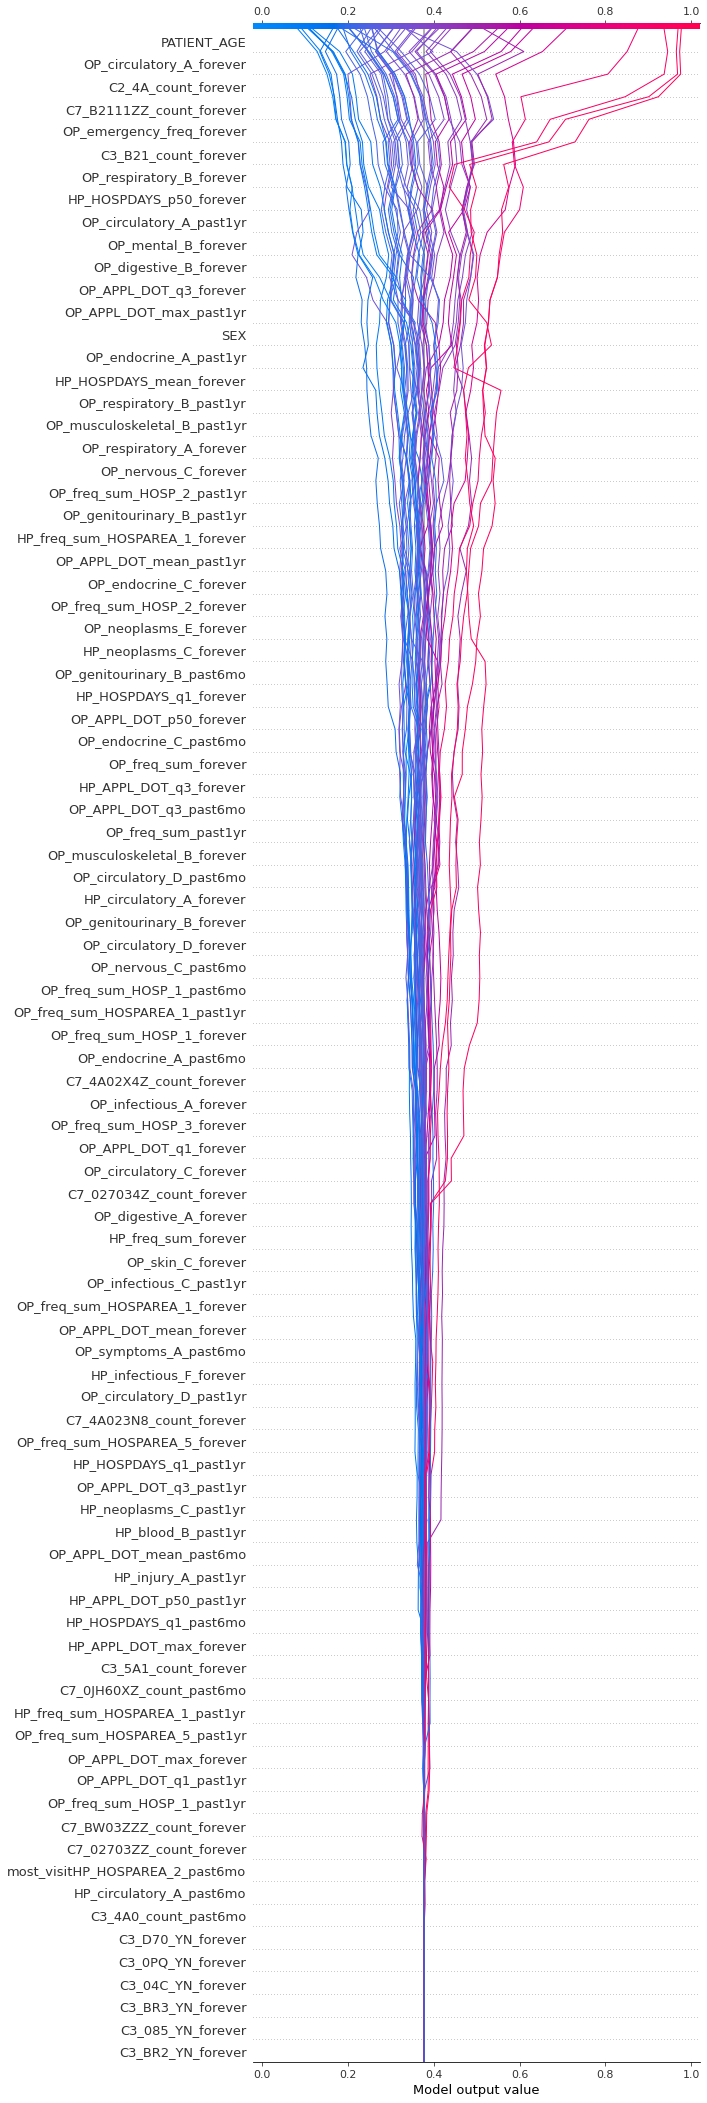

In [76]:
random.seed(a=17)
shap.decision_plot(explainer.expected_value,
                   shap_values[random.sample(
                       range(0, shap_values.shape[0]), 50)],
                   link='logit',
                   features=X_test, feature_display_range=slice(-1, -91, -1))

In [77]:
# q1 = explainer.shap_interaction_values(X_test)

In [78]:
# 取特徵
vals= np.abs(shap_values).mean(0)
shap_values_outcome = pd.DataFrame(list(zip(X_test.columns,vals)),columns=['feature_name', 'SHAP_vals'])
shap_values_outcome.sort_values(by=['SHAP_vals'],ascending=False,inplace=True)
shap_values_outcome

,feature_name,SHAP_vals
27,OP_circulatory_A_forever,0.254956
1,PATIENT_AGE,0.236776
4066,C2_4A_count_forever,0.162406
163,OP_emergency_freq_forever,0.105214
602,C7_B2111ZZ_count_forever,0.102868
...,...,...
7399,C3_0B2_YN_forever,0.000000
7398,C3_04J_YN_forever,0.000000
7397,C3_0FF_YN_forever,0.000000
7396,C3_0WP_YN_forever,0.000000


In [79]:
#shap_values_outcome.to_csv('./shap_values_outcome_model1_v4_wOP_0903.csv', index=False)

In [80]:
list(shap_values_outcome[shap_values_outcome['SHAP_vals']>0.01].feature_name.values)

['OP_circulatory_A_forever',
 'PATIENT_AGE',
 'C2_4A_count_forever',
 'OP_emergency_freq_forever',
 'C7_B2111ZZ_count_forever',
 'OP_respiratory_B_forever',
 'OP_circulatory_A_past1yr',
 'C3_B21_count_forever',
 'HP_HOSPDAYS_p50_forever',
 'OP_mental_B_forever',
 'OP_digestive_B_forever',
 'OP_APPL_DOT_q3_forever',
 'SEX',
 'OP_respiratory_B_past1yr',
 'OP_endocrine_A_past1yr',
 'OP_musculoskeletal_B_past1yr',
 'HP_HOSPDAYS_mean_forever',
 'OP_respiratory_A_forever',
 'OP_genitourinary_B_past1yr',
 'OP_APPL_DOT_mean_past1yr',
 'OP_nervous_C_forever',
 'OP_freq_sum_HOSP_2_past1yr',
 'HP_freq_sum_HOSPAREA_1_forever',
 'OP_APPL_DOT_max_past1yr',
 'HP_neoplasms_C_forever',
 'OP_endocrine_C_forever',
 'HP_HOSPDAYS_q1_forever',
 'OP_neoplasms_E_forever',
 'OP_freq_sum_HOSP_2_forever',
 'OP_genitourinary_B_past6mo',
 'OP_freq_sum_forever',
 'OP_APPL_DOT_q3_past6mo',
 'HP_APPL_DOT_q3_forever',
 'OP_APPL_DOT_p50_forever',
 'OP_endocrine_C_past6mo',
 'OP_freq_sum_past1yr',
 'OP_freq_sum_HOSP_1_forever',
 'OP_musculoskeletal_B_forever',
 'OP_circulatory_D_past6mo',
 'OP_genitourinary_B_forever',
 'OP_circulatory_D_forever',
 'HP_circulatory_A_forever',
 'OP_nervous_C_past6mo',
 'OP_freq_sum_HOSPAREA_1_past1yr']

In [38]:
SH_keep = list(shap_values_outcome[shap_values_outcome['SHAP_vals']>0.01].feature_name.values)
SH_keep.append('GKF')
SH_keep.append('case')
df_SH = df2[SH_keep]
df_SH

,OP_circulatory_A_forever,PATIENT_AGE,C7_4A023N7_YN_forever,OP_emergency_freq_forever,C2_B2_YN_forever,OP_circulatory_A_past1yr,OP_respiratory_B_forever,HP_HOSPDAYS_p50_forever,OP_APPL_DOT_q3_forever,OP_mental_B_forever,...,OP_freq_sum_forever,OP_freq_sum_past1yr,OP_genitourinary_B_past6mo,C7_B2111ZZ_count_forever,OP_nervous_C_forever,OP_APPL_DOT_p50_forever,OP_neoplasms_E_forever,OP_endocrine_C_past1yr,GKF,case
0,1,81,0.0,56.0,0.0,0,1,8.0,1645.00,1,...,6.0,3.0,0,0.0,1,950.0,0,0,1,1
1,1,68,1.0,6.0,1.0,1,1,3.0,762.25,1,...,6.0,4.0,0,3.0,1,315.0,1,1,4,1
2,1,80,0.0,0.0,0.0,1,0,3.0,829.00,1,...,5.0,2.0,0,0.0,0,560.0,0,1,2,1
3,0,73,0.0,28.0,1.0,0,1,9.0,1808.00,1,...,5.0,3.0,0,0.0,1,948.0,0,0,1,1
4,0,77,0.0,6.0,0.0,0,1,3.0,1132.00,0,...,9.0,8.0,1,0.0,0,510.0,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6621,0,60,NaN,8.0,NaN,0,0,NaN,1638.00,0,...,1.0,1.0,0,NaN,0,126.5,0,0,1,0
6622,1,63,NaN,0.0,NaN,1,0,NaN,3200.00,0,...,3.0,3.0,0,NaN,0,1410.0,0,0,5,0
6623,0,49,NaN,4.0,NaN,0,0,NaN,5480.00,1,...,2.0,2.0,1,NaN,0,1143.5,1,0,4,0
6624,0,54,NaN,0.0,NaN,0,0,NaN,6783.00,0,...,1.0,1.0,0,NaN,0,3832.5,0,0,3,0


In [37]:
def quick_testing_xgb(inn, risk_cut= 0.75, n_esti=80, lr=0.1, md=2, save=False, test_GBK=1, show_shap=False, sex=0):
    st=time.time()
    if sex==0:
        #inn = inn.drop('SEX', axis=1)
        inn = inn
    if sex!=0:
        inn = inn[inn.SEX == sex].reset_index(drop=True)
        #inn = inn.drop('SEX', axis=1)
        
    test_GBK = inn['GKF'] == test_GBK
    df_test = inn[test_GBK].drop('GKF', axis=1)
    df_train = inn[-test_GBK].drop('GKF', axis=1)
    X_train = df_train.drop('case', axis=1)
    X_test = df_test.drop('case', axis=1)
    y_train = df_train['case']
    y_test = df_test['case']
# modeling
    model_xgb = XGBClassifier(n_estimators=n_esti, learning_rate=lr, max_depth=md)

    model_xgb.fit(X_train, y_train)
    model_xgb_pred = model_xgb.predict(X_test)
    y_pred = model_xgb.predict_proba(X_test)[:, 1]
    # 模型成果
    print("Precision is {0:.2f}".format(precision_score(y_test, model_xgb_pred)))
    print("Recall is {0:.2f}".format(recall_score(y_test, model_xgb_pred)))
    print("Accuracy is {0:.2f}".format(accuracy_score(y_test, model_xgb_pred)))
    print("F1 is {0:.2f}".format(f1_score(y_test, model_xgb_pred)))
    print("ROC_AUC is {0:.3f}".format(roc_auc_score(y_test, y_pred)))
    
    DATA_Pred = pd.DataFrame(y_pred)
    threshold = DATA_Pred.quantile(risk_cut)
    
    DATA_Pred.columns = ['xgb_proba']
    y_test_removeindex = pd.DataFrame(y_test).reset_index(drop=True)
    DATA_Pred2 = pd.concat([DATA_Pred.xgb_proba, y_test_removeindex.case], axis=1)
    DATA_Pred2['XGB_p'] = np.where(DATA_Pred['xgb_proba'] >= threshold[0], 1, 0)
    DATA_Pred2.columns = ['xgb_proba', 'case', 'xgb_pred']

    binary = confusion_matrix(DATA_Pred2.case, DATA_Pred2.xgb_pred)
    # class_names = ['normal', 'higher']
    fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
    #                                 class_names=class_names
                               )
    plt.show()
    
    if show_shap:
        #SHAPE
        explainer = shap.TreeExplainer(model=model_xgb)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test, max_display = 40)
    
    #save model
    if save:
        joblib.dump(model_xgb, 'short_model_1_0924')
        print('dump to joblib')
    
    print(f'耗時 {round(time.time()-st,1)} sec')

Precision is 0.73
Recall is 0.45
Accuracy is 0.72
F1 is 0.56
ROC_AUC is 0.783


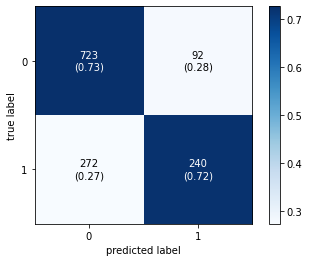

dump to joblib
耗時 1.0 sec


In [38]:
quick_testing_xgb(df_SH, test_GBK=1, save=True)

Precision is 0.71
Recall is 0.47
Accuracy is 0.72
F1 is 0.56
ROC_AUC is 0.767


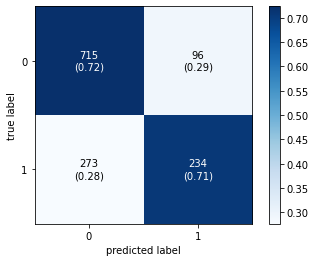

耗時 0.6 sec


In [39]:
quick_testing_xgb(df_SH, test_GBK=3)

Precision is 0.75
Recall is 0.50
Accuracy is 0.74
F1 is 0.60
ROC_AUC is 0.791


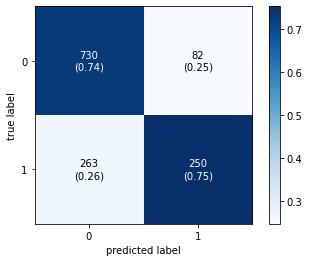

耗時 2.0 sec


In [40]:
quick_testing_xgb(df_SH, test_GBK=4)

Precision is 0.68
Recall is 0.43
Accuracy is 0.70
F1 is 0.52
ROC_AUC is 0.767


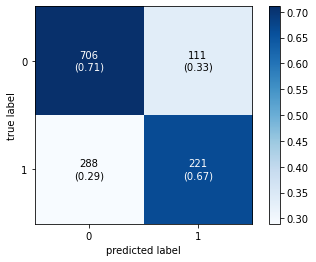

耗時 0.7 sec


In [41]:
quick_testing_xgb(df_SH, test_GBK=5)

In [43]:
SH_keep2 = list(shap_values_outcome[shap_values_outcome['SHAP_vals']>0.01].feature_name.values)
SH_keep2.append('GKF')
SH_keep2.append('case')
#SH_keep2.append('SEX')
SH_keep2.append('PID_STUDY')
df_SH2 = df[SH_keep2]
df_SH2.to_csv('./ABT_short_model_1_0924.csv', index=False)

## s by sex

Precision is 0.76
Recall is 0.48
Accuracy is 0.71
F1 is 0.59
ROC_AUC is 0.778


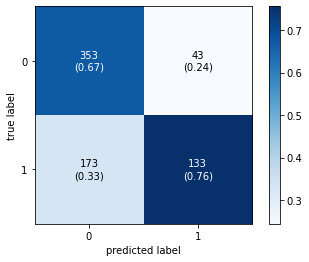

耗時 0.3 sec


In [44]:
quick_testing_xgb(df_SH, test_GBK=1, sex=1)

Precision is 0.67
Recall is 0.41
Accuracy is 0.74
F1 is 0.51
ROC_AUC is 0.765


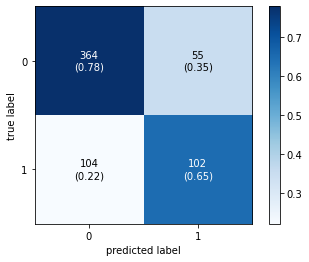

耗時 0.2 sec


In [45]:
quick_testing_xgb(df_SH, test_GBK=1, sex=2)